# Задача 7. Нейронные сети
- Найти данные в виде изображений для задачи классификации. Например, можно взять данные отсюда.
- Реализовать классы, необходимые для построения сети со следующими слоями

    - FullyConnectedLayer
    - ReluLayer
    - FullyConnectedLayer

- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (+2 балла) Добавить Batch normalization.
- (+2 балла) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (+1 балл) Также реализовать оптимизатор Adam.

# Датасет

[Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) -  датасет 32×32 RGB изображений домовых номеров, извлеченных из фотографий Google Street View

In [1]:
!curl -o train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!curl -o test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!curl -o extra_32x32.mat http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 53  173M   53 92.0M    0     0  7490k      0  0:00:23  0:00:12  0:00:11 13.9M^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 61.2M    0  129k    0     0  98882      0  0:10:50  0:00:01  0:10:49 98849^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 1267M    0 83718    0     0  82304      0  4:29:10  0:00:01  4:29:09 82318^C


# GPU

In [2]:
!nvidia-smi

Thu Jun 19 14:47:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install torch torchvision
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Классы слоёв

In [5]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, output_size, reg_lambda=0.01):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(input_size, output_size) * 0.01)
        self.bias = nn.Parameter(torch.zeros(1, output_size))
        self.reg_lambda = reg_lambda

    def forward(self, x):
        return x @ self.weights + self.bias

    def regularization_loss(self):
        return self.reg_lambda * torch.sum(self.weights ** 2)


In [6]:
class ReluLayer(nn.Module):
    def forward(self, x):
        return F.relu(x)


In [7]:
class BatchNormLayer(nn.Module):
    def __init__(self, num_features, momentum=0.9, epsilon=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, num_features))
        self.beta = nn.Parameter(torch.zeros(1, num_features))
        self.momentum = momentum
        self.epsilon = epsilon
        self.register_buffer('running_mean', torch.zeros(1, num_features))
        self.register_buffer('running_var', torch.ones(1, num_features))

    def forward(self, x, training=True):
        if training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True, unbiased=False)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.gamma * x_hat + self.beta


In [8]:
class CrossEntropyLoss(nn.Module):
    def forward(self, logits, labels):
        log_probs = F.log_softmax(logits, dim=1)
        return F.nll_loss(log_probs, labels)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform
)
# extra_set = torchvision.datasets.SVHN(
#     root='./data', split='extra', download=True, transform=transform
# )
test_set = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform
)

train_set = torch.utils.data.ConcatDataset([train_set])

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    train_set, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Используемое устройство: cuda


# Оптимизации

In [10]:
class MomentumOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9):
        defaults = {'lr': lr, 'momentum': momentum}
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(p.data)

                buf = state['momentum_buffer']
                buf.mul_(group['momentum']).add_(p.grad.data)
                p.data.add_(-group['lr'], buf)


In [11]:
class AdamOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        defaults = {'lr': lr, 'betas': betas, 'eps': eps}
        super().__init__(params, defaults)
        self.step_count = 0

    def step(self):
        self.step_count += 1
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                state['step'] += 1
                beta1, beta2 = group['betas']

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(1 - beta1, p.grad.data)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, p.grad.data, p.grad.data)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2 ** 0.5) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, exp_avg_sq.sqrt().add_(group['eps']))


# Класс нейронной сети
Структура сети: Input(3072) -> FullyConnected(512)-> BatchNorm -> ReLU -> FullyConnected(10) -> Output

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_batchnorm=False, reg_lambda=0.01):
        super().__init__()
        self.fc1 = FullyConnectedLayer(input_size, hidden_size, reg_lambda)
        self.relu = ReluLayer()
        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = BatchNormLayer(hidden_size)

        self.fc2 = FullyConnectedLayer(hidden_size, output_size, reg_lambda)
        self.loss = CrossEntropyLoss()

    def forward(self, x, labels=None):
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x, training=self.training)

        x = self.relu(x)
        x = self.fc2(x)

        if labels is not None:
            loss_val = self.loss(x, labels)
            reg_loss = self.fc1.regularization_loss() + self.fc2.regularization_loss()
            return loss_val + reg_loss
        return x

    def get_regularization_loss(self):
        return self.fc1.regularization_loss() + self.fc2.regularization_loss()

# Обучение с проверкий градиента

In [13]:
def gradient_check(model, data_loader, epsilon=1e-5, num_checks=50):
    model.eval()
    inputs, labels = next(iter(data_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    inputs_flat = inputs.view(inputs.size(0), -1)

    loss = model(inputs_flat, labels)
    model.zero_grad()
    loss.backward()
    analytic_grads = [p.grad.clone() for p in model.parameters() if p.requires_grad]

    for param_idx, param in enumerate(model.parameters()):
        if not param.requires_grad or param.grad is None:
            continue

        flat_param = param.data.view(-1)
        indices = torch.randperm(len(flat_param))[:num_checks]

        for idx in indices:
            original_val = flat_param[idx].item()

            flat_param[idx] = original_val + epsilon
            loss_plus = model(inputs_flat, labels)

            flat_param[idx] = original_val - epsilon
            loss_minus = model(inputs_flat, labels)

            flat_param[idx] = original_val

            numeric_grad = (loss_plus.item() - loss_minus.item()) / (2 * epsilon)

            analytic_grad = analytic_grads[param_idx].view(-1)[idx].item()

            rel_error = abs(numeric_grad - analytic_grad) / max(1e-8, abs(numeric_grad) + abs(analytic_grad))

            if rel_error > 1e-4:
                print(f"Param {param_idx}, index {idx}: "
                      f"Numerical: {numeric_grad:.6f}, Analytic: {analytic_grad:.6f}, "
                      f"Error: {rel_error:.2e}")

    print("Gradient chack completed")

def train_model(model, train_loader, val_loader, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model(inputs.view(inputs.size(0), -1), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            with torch.no_grad():
                logits = model(inputs.view(inputs.size(0), -1))
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.1f}s | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs_flat = inputs.view(inputs.size(0), -1)

            loss = model(inputs_flat, labels)
            running_loss += loss.item()

            logits = model(inputs_flat)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(loader)
    acc = 100. * correct / total
    return loss, acc


# Сравнение оптимизаций и перебор гиперпараметров

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

use_batchnorm_options = [True, False]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
optimizers = {
    'Momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'Adam': lambda params, lr: optim.Adam(params, lr=lr)
}

results = {
    'train_loss': {opt: {lr: {bn: [] for bn in use_batchnorm_options}
                         for lr in learning_rates}
                   for opt in optimizers},
    'val_loss': {opt: {lr: {bn: [] for bn in use_batchnorm_options}
                       for lr in learning_rates}
                 for opt in optimizers},
    'train_acc': {opt: {lr: {bn: [] for bn in use_batchnorm_options}
                        for lr in learning_rates}
                  for opt in optimizers},
    'val_acc': {opt: {lr: {bn: [] for bn in use_batchnorm_options}
                      for lr in learning_rates}
                for opt in optimizers},
    'time': {opt: {lr: {bn: 0 for bn in use_batchnorm_options}
                   for lr in learning_rates}
             for opt in optimizers}
}

input_size = 3 * 32 * 32
hidden_size = 512
output_size = 10
epochs = 10

for use_batchnorm in use_batchnorm_options:
    for lr in learning_rates:
        for opt_name, opt_func in optimizers.items():
            print(f"\n{'='*50}")
            print(f"Training: BN={use_batchnorm}, LR={lr}, Optimizer={opt_name}")
            print(f"{'='*50}")

            model = NeuralNetwork(
                input_size,
                hidden_size,
                output_size,
                use_batchnorm=use_batchnorm,
                reg_lambda=0.001
            ).to(device)

            optimizer = opt_func(model.parameters(), lr)

            criterion = nn.CrossEntropyLoss()

            start_time = time.time()

            for epoch in range(epochs):
                model.train()
                train_loss, train_correct, train_total = 0, 0, 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(inputs.size(0), -1)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    train_total += labels.size(0)
                    train_correct += predicted.eq(labels).sum().item()

                model.eval()
                val_loss, val_correct, val_total = 0, 0, 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        inputs = inputs.view(inputs.size(0), -1)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()
                        _, predicted = outputs.max(1)
                        val_total += labels.size(0)
                        val_correct += predicted.eq(labels).sum().item()

                train_loss_avg = train_loss / len(train_loader)
                val_loss_avg = val_loss / len(val_loader)
                train_acc = 100. * train_correct / train_total
                val_acc = 100. * val_correct / val_total

                results['train_loss'][opt_name][lr][use_batchnorm].append(train_loss_avg)
                results['val_loss'][opt_name][lr][use_batchnorm].append(val_loss_avg)
                results['train_acc'][opt_name][lr][use_batchnorm].append(train_acc)
                results['val_acc'][opt_name][lr][use_batchnorm].append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}: "
                      f"Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f} | "
                      f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

            elapsed = time.time() - start_time
            results['time'][opt_name][lr][use_batchnorm] = elapsed
            print(f"Training completed in {elapsed:.2f} seconds")



Training: BN=True, LR=0.1, Optimizer=Momentum
Epoch 1/10: Train Loss: 1.4482, Val Loss: 1.3056 | Train Acc: 54.09%, Val Acc: 61.30%
Epoch 2/10: Train Loss: 0.9778, Val Loss: 0.9161 | Train Acc: 70.16%, Val Acc: 72.29%
Epoch 3/10: Train Loss: 0.8132, Val Loss: 0.8649 | Train Acc: 75.60%, Val Acc: 75.05%
Epoch 4/10: Train Loss: 0.7386, Val Loss: 0.7883 | Train Acc: 77.97%, Val Acc: 76.92%
Epoch 5/10: Train Loss: 0.6741, Val Loss: 0.7186 | Train Acc: 79.98%, Val Acc: 79.92%
Epoch 6/10: Train Loss: 0.6349, Val Loss: 0.7228 | Train Acc: 81.27%, Val Acc: 79.91%
Epoch 7/10: Train Loss: 0.6150, Val Loss: 0.7328 | Train Acc: 81.80%, Val Acc: 79.18%
Epoch 8/10: Train Loss: 0.5787, Val Loss: 0.6592 | Train Acc: 82.93%, Val Acc: 81.37%
Epoch 9/10: Train Loss: 0.5564, Val Loss: 0.6601 | Train Acc: 83.48%, Val Acc: 81.35%
Epoch 10/10: Train Loss: 0.5353, Val Loss: 0.6547 | Train Acc: 84.13%, Val Acc: 81.83%
Training completed in 188.31 seconds

Training: BN=True, LR=0.1, Optimizer=Adam
Epoch 1/10: 

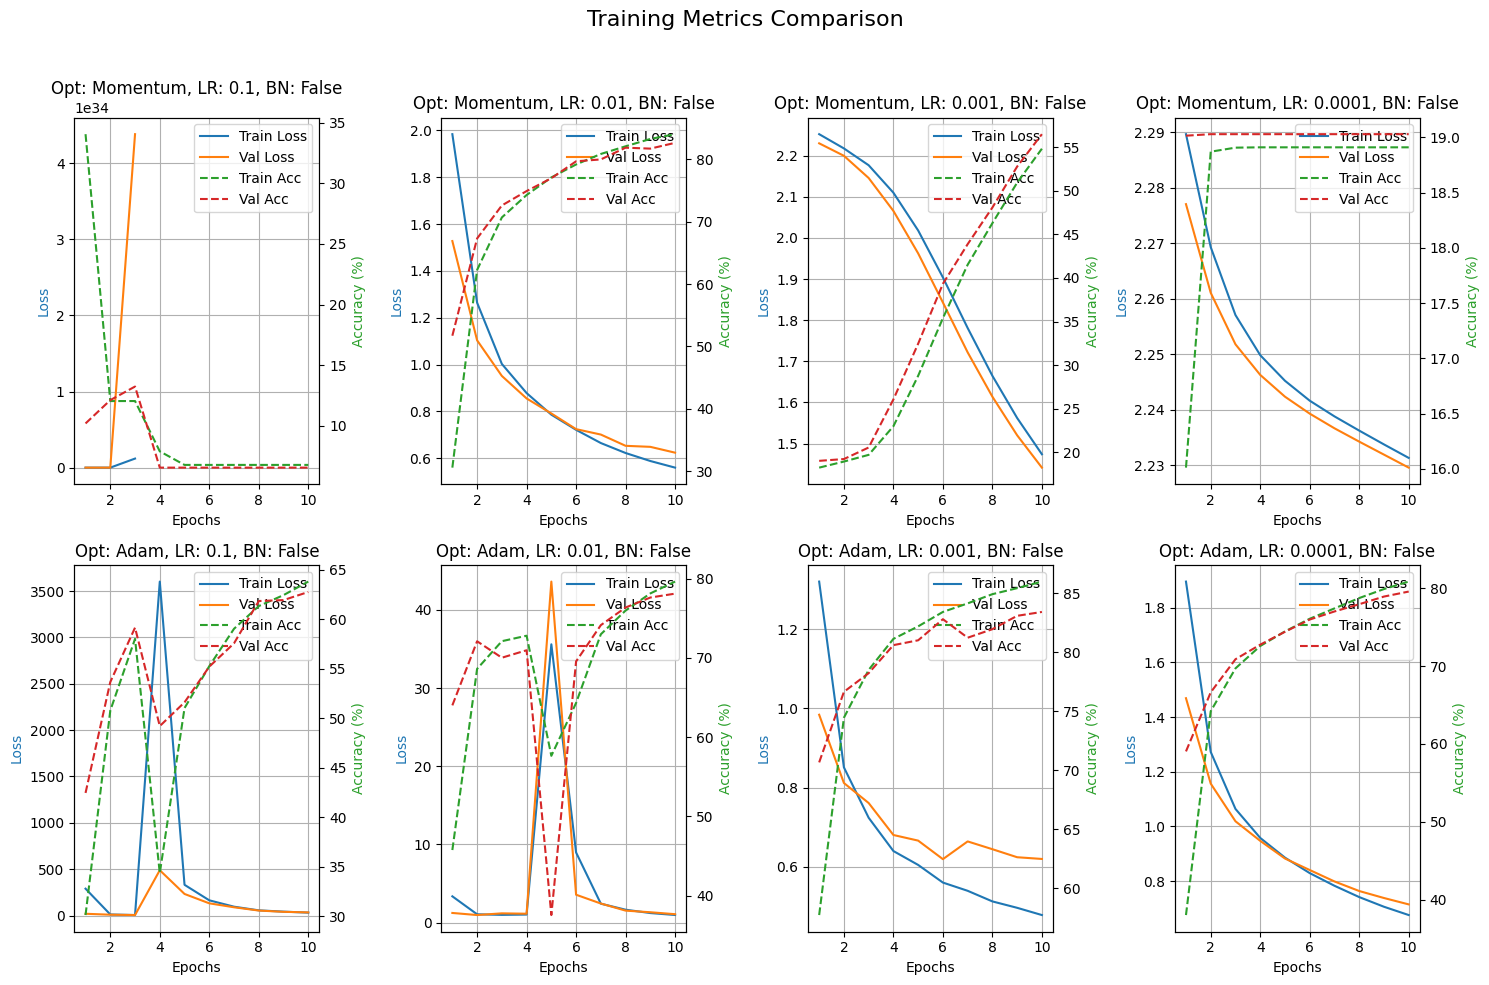


Best Validation Accuracy:
Optimizer | Learning Rate | BatchNorm | Best Val Acc | Time (s)
-----------------------------------------------------------------
Momentum  | 0.1           | True      | 81.83%       | 188.3
Momentum  | 0.1           | False     | 13.24%       | 191.6
Momentum  | 0.01          | True      | 82.91%       | 188.7
Momentum  | 0.01          | False     | 82.66%       | 184.0
Momentum  | 0.001         | True      | 80.26%       | 189.1
Momentum  | 0.001         | False     | 56.48%       | 187.3
Momentum  | 0.0001        | True      | 52.89%       | 189.8
Momentum  | 0.0001        | False     | 19.03%       | 185.6
Adam      | 0.1           | True      | 62.80%       | 192.9
Adam      | 0.1           | False     | 62.78%       | 188.0
Adam      | 0.01          | True      | 81.27%       | 191.9
Adam      | 0.01          | False     | 78.09%       | 184.8
Adam      | 0.001         | True      | 83.18%       | 188.5
Adam      | 0.001         | False     | 83.42%    

In [15]:
def plot_combined_results():
    plt.figure(figsize=(15, 10))
    colors = {
        'train_loss': 'tab:blue',
        'val_loss': 'tab:orange',
        'train_acc': 'tab:green',
        'val_acc': 'tab:red'
    }
    linestyles = {
        'loss': '-',
        'acc': '--'
    }

    grid_spec = plt.GridSpec(len(optimizers), len(learning_rates))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    for i, opt_name in enumerate(optimizers):
        for j, lr in enumerate(learning_rates):
            ax = plt.subplot(grid_spec[i, j])
            ax2 = ax.twinx()

            train_loss = results['train_loss'][opt_name][lr][use_batchnorm]
            val_loss = results['val_loss'][opt_name][lr][use_batchnorm]
            train_acc = results['train_acc'][opt_name][lr][use_batchnorm]
            val_acc = results['val_acc'][opt_name][lr][use_batchnorm]
            epochs_list = range(1, len(train_loss) + 1)

            ax.plot(epochs_list, train_loss,
                    color=colors['train_loss'],
                    linestyle=linestyles['loss'],
                    label='Train Loss')
            ax.plot(epochs_list, val_loss,
                    color=colors['val_loss'],
                    linestyle=linestyles['loss'],
                    label='Val Loss')

            ax2.plot(epochs_list, train_acc,
                     color=colors['train_acc'],
                     linestyle=linestyles['acc'],
                     label='Train Acc')
            ax2.plot(epochs_list, val_acc,
                     color=colors['val_acc'],
                     linestyle=linestyles['acc'],
                     label='Val Acc')

            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss', color='tab:blue')
            ax2.set_ylabel('Accuracy (%)', color='tab:green')
            ax.set_title(f'Opt: {opt_name}, LR: {lr}, BN: {use_batchnorm}')
            ax.grid(True)

            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.suptitle('Training Metrics Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('combined_metrics.png')
    plt.show()

plot_combined_results()


print("\nBest Validation Accuracy:")
print("Optimizer | Learning Rate | BatchNorm | Best Val Acc | Time (s)")
print("-" * 65)

for opt_name in optimizers:
    for lr in learning_rates:
        for use_batchnorm in use_batchnorm_options:
            best_acc = max(results['val_acc'][opt_name][lr][use_batchnorm])
            time_elapsed = results['time'][opt_name][lr][use_batchnorm]
            print(f"{opt_name:<9} | {lr:<13} | {str(use_batchnorm):<9} | {best_acc:.2f}%       | {time_elapsed:.1f}")


# Результат
Лучшей комбинацией получилась:

Оптимизация - Adam, Learning Rate - 0.001, BatchNorm - False